# BGS Signal-to-Noise Ratio and Redshift Efficiency

Simulation 1:
* Nominal exposure time (300 sec)
* Fixed r mag (19.5)
* Redshift range 0.2+/-0.05
* Fixed moon zenith (30 deg)
* Fixed moon angle (50 deg)
* Vary moon fraction (phase) (0-1)


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

In [2]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2 

In [3]:
from desisim.scripts.quickspectra import sim_spectra
from desisim.simexp import reference_conditions
from desisim.io import read_basis_templates
from desisim.templates import BGS
from desispec.io.util import write_bintable, fitsheader
from redrock.external.desi import rrdesi

In [4]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [5]:
simdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'sim', 'bgs')

### Characterize the BGS templates.

In [6]:
bgs = BGS(minwave=3500.0)

INFO:io.py:967:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits


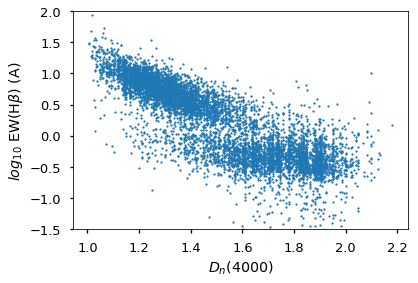

In [7]:
fig, ax = plt.subplots()
_ = ax.scatter(bgs.basemeta['D4000'], np.log10(bgs.basemeta['HBETA_EW']), s=3)
ax.set_ylim(-1.5, 2)
ax.set_xlabel(r'$D_{n}(4000)$')
ax.set_ylabel(r'$log_{10}$ EW(H$\beta$) (A)')

## Set up the simulations.

In [8]:
sim1 = dict(suffix='sim01',
            nsim=3,
            nspec=10,
            seed=111,
            rmin=19.5, rmax=19.5,
            zmean=0.2, zsig=0.05,
            moonfracmin=0.0, moonfracmax=1.0,
           )

In [9]:
program = 'bgs'
ref_obsconditions = reference_conditions[program.upper()]
ref_obsconditions

{'AIRMASS': 1.0,
 'EXPTIME': 300,
 'MOONALT': 60,
 'MOONFRAC': 0.7,
 'MOONSEP': 50,
 'SEEING': 1.1}

In [10]:
def bgs_write_simdata(sim, rand, overwrite=False):
    """Build and write a metadata table with the simulation inputs.
    
    """
    simdatafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-simdata.fits'.format(sim['suffix']))
        
    cols = [
        ('SEED', 'S20'),
        ('NSPEC', 'i4'),
        ('EXPTIME', 'f4'),
        ('AIRMASS', 'f4'),
        ('SEEING', 'f4'),
        ('MOONFRAC', 'f4'),
        ('MOONSEP', 'f4'),
        ('MOONALT', 'f4')]
    simdata = Table(np.zeros(sim['nsim'], dtype=cols))
    
    simdata['EXPTIME'].unit = 's'
    simdata['SEEING'].unit = 'arcsec'
    simdata['MOONSEP'].unit = 'deg'
    simdata['MOONALT'].unit = 'deg'

    simdata['SEED'] = sim['seed']
    simdata['NSPEC'] = sim['nspec']
    simdata['AIRMASS'] = ref_obsconditions['AIRMASS']
    simdata['SEEING'] = ref_obsconditions['SEEING']
    simdata['MOONALT'] = ref_obsconditions['MOONALT']
    
    if 'moonfracmin' in sim.keys():
        simdata['MOONFRAC'] = rand.uniform(sim['moonfracmin'], sim['moonfracmax'], sim['nsim'])
    else:
        simdata['MOONFRAC'] = ref_obsconditions['MOONFRAC']

    if 'moonsepmin' in sim.keys():
        simdata['MOONSEP'] = rand.uniform(sim['moonsepmin'], sim['moonsepmax'], sim['nsim'])
    else:
        simdata['MOONSEP'] = ref_obsconditions['MOONSEP']
        
    if 'exptime' in sim.keys():
        simdata['EXPTIME'] = rand.uniform(sim['exptimmin'], sim['exptimemax'], sim['nsim'])
    else:
        simdata['EXPTIME'] = ref_obsconditions['EXPTIME']
        
    if overwrite or not os.path.isfile(simdatafile):     
        print('Writing {}'.format(simdatafile))
        write_bintable(simdatafile, simdata, extname='SIMDATA')
        
    return simdata

In [11]:
def simdata2obsconditions(simdata):
    obs = dict(AIRMASS=simdata['AIRMASS'], 
               EXPTIME=simdata['EXPTIME'],
               MOONALT=simdata['MOONALT'],
               MOONFRAC=simdata['MOONFRAC'],
               MOONSEP=simdata['MOONSEP'],
               SEEING=simdata['SEEING'])
    return obs

In [12]:
def bgs_sim_spectra(sim, overwrite=False):
    """Generate spectra for a given simulation with the option of overwriting files.
    
    """
    rand = np.random.RandomState(sim['seed'])
    
    # Generate the rest-frame templates.  Note that we're generating the *same* spectra
    # and only varying the observing conditions.
    redshift = rand.normal(loc=sim['zmean'], scale=sim['zsig'], size=sim['nspec'])
    rmag = rand.uniform(sim['rmin'], sim['rmax'], size=sim['nspec'])
    flux, wave, meta = bgs.make_templates(nmodel=sim1['nspec'], redshift=redshift, 
                                          mag=rmag, seed=sim['seed'])
    metadatafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-metadata.fits'.format(sim['suffix']))
    if overwrite or not os.path.isfile(metadatafile):    
        print('Writing {}'.format(metadatafile))
        write_bintable(metadatafile, meta, extname='METADATA', clobber=True,
                       header=fitsheader(dict(SIM = (sim['suffix'], 'simulation number'))))
    
    # Generate the list of observing conditions dictionaries.
    simdata = bgs_write_simdata(sim, rand, overwrite=overwrite)

    for ii, simdata1 in enumerate(simdata):
        obs = simdata2obsconditions(simdata1)
        print(obs)
        spectrafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}.fits'.format(sim['suffix'], ii))
        if overwrite or not os.path.isfile(spectrafile):
            sim_spectra(wave, flux[:10, :], program, spectrafile, obsconditions=obs, 
                        sourcetype='bgs', seed=sim['seed'], expid=ii)
        else:
            print('File {} exists...skipping.'.format(spectrafile))

## Generate the spectra.

In [13]:
for sim in np.atleast_1d(sim1):
    bgs_sim_spectra(sim, overwrite=False)

{'MOONFRAC': 0.79396256047962843, 'EXPTIME': 300.0, 'MOONALT': 60.0, 'AIRMASS': 1.0, 'SEEING': 1.1, 'MOONSEP': 50.0}
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-000.fits exists...skipping.
{'MOONFRAC': 0.84056964872428119, 'EXPTIME': 300.0, 'MOONALT': 60.0, 'AIRMASS': 1.0, 'SEEING': 1.1, 'MOONSEP': 50.0}
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-001.fits exists...skipping.
{'MOONFRAC': 0.81520745745294065, 'EXPTIME': 300.0, 'MOONALT': 60.0, 'AIRMASS': 1.0, 'SEEING': 1.1, 'MOONSEP': 50.0}
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-002.fits exists...skipping.


## Fit the redshifts.

In [26]:
def bgs_redshifts(sim, overwrite=False):
    """Fit for the redshifts.
    
    """
    for ii in range(sim['nsim']):
        zbestfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}-zbest.fits'.format(sim['suffix'], ii))
        spectrafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}.fits'.format(sim['suffix'], ii))
    
        if overwrite or not os.path.isfile(zbestfile):
            rrdesi(options=['--zbest', zbestfile, '--ncpu', str(nproc), spectrafile])
        else:
            print('File {} exists...skipping.'.format(zbestfile))    

In [27]:
for sim in np.atleast_1d(sim1):
    bgs_redshifts(sim, overwrite=False)

INFO: reading targets
INFO: reading templates
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-galaxy.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-star-B.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-qso.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-star-A.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-star-M.fits, using default values
INFO: Can't find redshift range info in template file /Users/ioannis/repos/desihub/redrock/py/redrock/templates/rrtemplate-star-F.fits, using default values
INFO: Can't fin

## Gather the results.

In [ ]:
def bgs_gather_results(sim, overwrite=False):
    """Gather all the pieces so we can make plots.
    
    """
    nspec = sim['nspec'] * sim['nsim']
    
    resultfile = makepath(os.path.join(simsdir, '{}-results.fits'.format(brickname)))
    cols = [
        ('EXPTIME', 'f4'),
        ('AIRMASS', 'f4'),
        ('MOONFRAC', 'f4'),
        ('MOONSEP', 'f4'),
        ('MOONALT', 'f4'),
        ('SNR_B', 'f4'),
        ('SNR_R', 'f4'),
        ('SNR_Z', 'f4'),
        ('TARGETID', 'i8'),
        ('RMAG', 'f4'),
        ('D4000', 'f4'),
        ('EWHBETA', 'f4'), 
        ('ZTRUE', 'f4'), 
        ('Z', 'f4'), 
        ('ZERR', 'f4'), 
        ('ZWARN', 'f4')]
    result = Table(np.zeros(nspec, dtype=cols))

    result['EXPTIME'].unit = 's'
    result['MOONSEP'].unit = 'deg'
    result['MOONALT'].unit = 'deg'
    
    # Read the simulation data table and the template metadata table.
    simdatafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-simdata.fits'.format(sim['suffix']))
    simdata = Table.read(simdatafile)

    metadatafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-metadata.fits'.format(sim['suffix']))
    meta = Table.read(metadatafile)
        
    for ii in range(sim['nsim']):
        # Copy over some data.
        result['EXPTIME'][nspec*ii:nspec*(ii+1)] = cat['EXPTIME'][ii]
        result['AIRMASS'][nspec*ii:nspec*(ii+1)] = cat['AIRMASS'][ii]
        result['MOONFRAC'][nspec*ii:nspec*(ii+1)] = cat['MOONFRAC'][ii]
        result['MOONSEP'][nspec*ii:nspec*(ii+1)] = cat['MOONSEP'][ii]
        result['MOONALT'][nspec*ii:nspec*(ii+1)] = cat['MOONALT'][ii]
        
            # Read the truth file of the first channel to get the metadata.
            truthfile = os.path.join(brickdir, thisbrick, 'truth-brick-{}-{}.fits'.format('b', thisbrick))
            log.info('Reading {}'.format(truthfile))
            truth = io.Brick(truthfile).hdu_list[4].data

            result['TARGETID'][nspec*ib:nspec*(ib+1)] = truth['TARGETID']
            result['RMAG'][nspec*ib:nspec*(ib+1)] = 22.5-2.5*np.log10(truth['DECAM_FLUX'][:,2])
            result['D4000'][nspec*ib:nspec*(ib+1)] = truth['D4000']
            result['EWHBETA'][nspec*ib:nspec*(ib+1)] = truth['EWHBETA']
            result['ZTRUE'][nspec*ib:nspec*(ib+1)] = truth['TRUEZ']

            # Finally read the zbest file. 
            zbestfile = os.path.join(brickdir, thisbrick, 'zbest-{}.fits'.format(thisbrick))
            if os.path.isfile(zbestfile):
                log.info('Reading {}'.format(zbestfile))
                zbest = read_zbest(zbestfile)
                # There's gotta be a better way than looping here!
                for ii in range(nspec):
                    this = np.where(zbest.targetid[ii] == result['TARGETID'])[0]
                    result['Z'][this] = zbest.z[ii]
                    result['ZERR'][this] = zbest.zerr[ii]
                    result['ZWARNING'][this] = zbest.zwarn[ii]

            #pdb.set_trace()
                    
            # Finally, read the spectra and truth tables, one per channel.
            for channel in ('b','r','z'):
                brickfile = os.path.join(brickdir, thisbrick, 'brick-{}-{}.fits'.format(channel, thisbrick))

                log.info('Reading {}'.format(brickfile))
                brick = io.Brick(brickfile)
                wave = brick.get_wavelength_grid()

                for iobj in range(nspec):
                    flux = brick.hdu_list[0].data[iobj,:]
                    ivar = brick.hdu_list[1].data[iobj,:]
                    these = np.where((wave>np.mean(wave)-50)*(wave<np.mean(wave)+50)*(flux>0))[0]
                    result['SNR_'+channel.upper()][nspec*ib+iobj] = \
                      np.median(np.sqrt(flux[these]*ivar[these]))



In [ ]:
for sim in np.atleast_1d(sim1):
    bgs_gather_results(sim, overwrite=True)

## Analyze the outputs.